In [2]:
import os
import time
import uuid
import cv2

In [11]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [ ]:
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Failed to open camera.")
    exit()
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    if not ret:
        print("Error: Failed to capture frame.")
        continue
    imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    if not imgname:
        print("Error: Invalid image name.")
        continue
    cv2.imwrite(imgname, frame)
    time.sleep(0.5)
cap.release()

In [ ]:
!labelme

2024-03-01 08:33:44,711 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\Abhishek A\.labelmerc


In [1]:
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt

In [3]:
import tensorflow as tf

In [4]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
images=tf.data.Dataset.list_files('data/images/*.jpg')

In [ ]:
images.as_numpy_iterator().next()

In [ ]:
def load_image(x):
    byte_img=tf.io.read_file(x)
    img=tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
images=images.map(load_image)

In [ ]:
images.as_numpy_iterator().next()

In [ ]:
type(images)

In [ ]:
image_generator=images.batch(4).as_numpy_iterator()

In [ ]:
plot_images=image_generator.next()

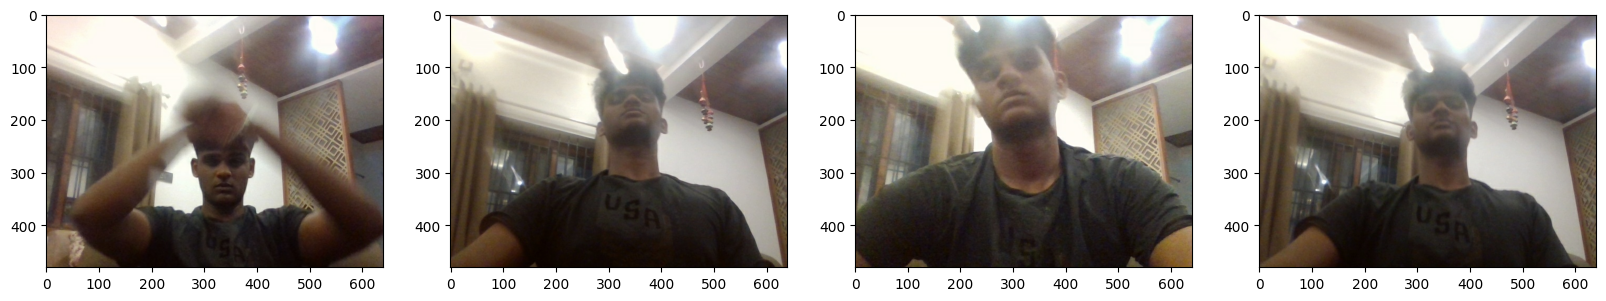

In [ ]:
fig,ax=plt.subplots(ncols=4,figsize=(20,20))
for idx,image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

In [ ]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data',folder,'images')):
        filename=file.split('.')[0]+'.json'
        existing_filepath=os.path.join('data','labels',filename)
        if os.path.exists(existing_filepath):
            new_filepath=os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath,new_filepath)

In [ ]:
import albumentations as alb

In [ ]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [ ]:
img=cv2.imread(os.path.join('data','train','images','4e129638-c814-11ee-8012-842afd0ff2bb.jpg'))
with open(os.path.join('data','train','labels','4e129638-c814-11ee-8012-842afd0ff2bb.json'),'r') as f:
    label=json.load(f)

In [ ]:
label

{'version': '5.4.1',
 'flags': {},
 'shapes': [{'label': 'face',
   'points': [[256.71875, 86.35416666666664],
    [437.96875000000006, 333.22916666666663]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {},
   'mask': None}],
 'imagePath': '..\\images\\4e129638-c814-11ee-8012-842afd0ff2bb.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkN

In [ ]:
coords=[0,0,0,0]
coords[0]=label['shapes'][0]['points'][0][0]
coords[1]=label['shapes'][0]['points'][0][1]
coords[2]=label['shapes'][0]['points'][1][0]
coords[3]=label['shapes'][0]['points'][1][1]

In [27]:
coords

[256.71875, 86.35416666666664, 437.96875000000006, 333.22916666666663]

In [28]:
coords=list(np.divide(coords,[640,480,640,480]))

In [29]:
augumented=augmentor(image=img,bboxes=[coords],class_labels=['face'])

In [30]:
augumented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

In [31]:
augumented['bboxes'][0][2:]

(0.9377083333333335, 0.8303240740740742)

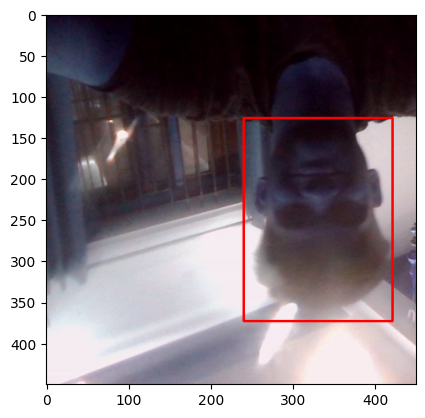

In [32]:
cv2.rectangle(augumented['image'],
              tuple(np.multiply(augumented['bboxes'][0][:2],[450,450]).astype(int)),
              tuple(np.multiply(augumented['bboxes'][0][2:],[450,450]).astype(int)),
                (255,0,0),2)
plt.imshow(augumented['image'])

In [35]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.2798665364583333, 0.28515625, 0.06827799479166666, 0.7528211805555555, 'face'].
x_max is less than or equal to x_min for bbox [0.6696777343750001, 0.36111111111111105, 0.322998046875, 0.0008680555555555062, 'face'].
x_max is less than or equal to x_min for bbox [0.6656087239583333, 0.5434027777777778, 0.3164876302083333, 0.007378472222222173, 'face'].
x_max is less than or equal to x_min for bbox [0.6550292968750001, 0.36328125, 0.3384602864583333, 0.0041232638888888395, 'face'].


In [36]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [37]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [38]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [ ]:
train_images.as_numpy_iterator().next()

In [56]:
def load_labels(label_path):
    with open(label_path.numpy(),'r',encoding="utf-8") as f:
        label=json.load(f)
    return [label['class']],label['bbox']

In [57]:
train_labels=tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json',shuffle=False)
train_labels=train_labels.map(lambda x:tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))

In [58]:
test_labels=tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json',shuffle=False)
test_labels=test_labels.map(lambda x:tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))

In [59]:
val_labels=tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json',shuffle=False)
val_labels=val_labels.map(lambda x:tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))

In [60]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.2793, 0.1542, 0.682 , 0.7026], dtype=float16))

In [61]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(1020, 1020, 4800, 4800, 960, 960)

In [62]:
train=tf.data.Dataset.zip((train_images,train_labels))
train=train.shuffle(5000)
train=train.batch(8)
train=train.prefetch(4)

In [64]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [65]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [70]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[2.712e-01, 1.243e-01, 8.696e-01, 6.265e-01],
        [0.000e+00, 3.555e-01, 1.566e-01, 8.486e-01],
        [0.000e+00, 5.083e-01, 6.299e-01, 1.000e+00],
        [2.273e-01, 5.688e-01, 6.426e-01, 9.380e-01],
        [7.281e-02, 1.188e-01, 7.476e-01, 8.652e-01],
        [0.000e+00, 1.458e-01, 2.998e-01, 6.968e-01],
        [0.000e+00, 4.168e-04, 4.280e-01, 6.255e-01],
        [6.323e-01, 1.741e-01, 1.000e+00, 6.323e-01]], dtype=float16))

In [67]:
data_samples=train.as_numpy_iterator()

In [73]:
res=data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


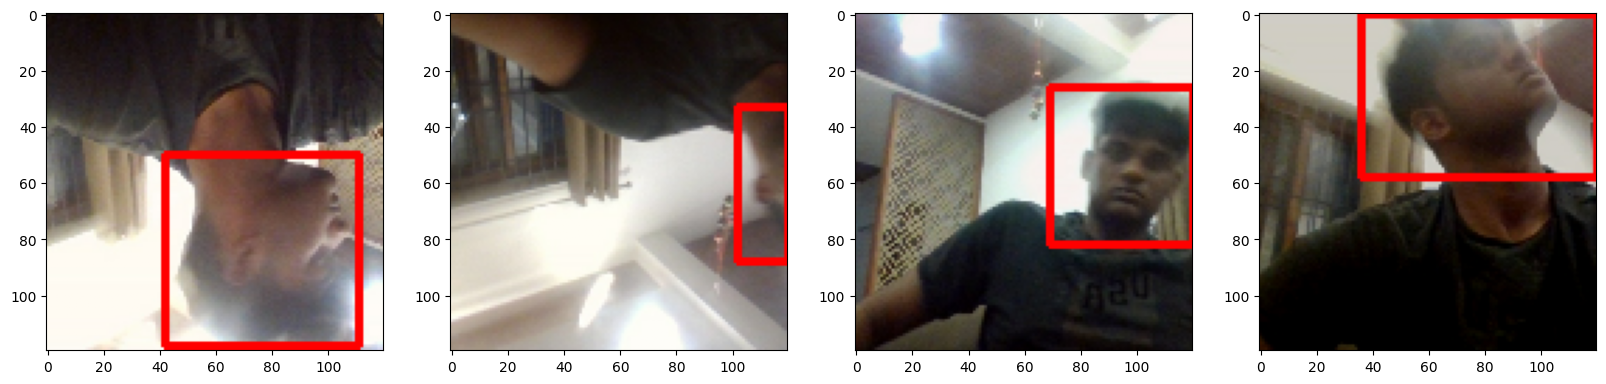

In [74]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    sample_image_copy = sample_image.copy()
    cv_image = cv2.UMat(sample_image_copy)
    cv2.rectangle(cv_image, 
                  tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)), 
                  (255, 0, 0), 2)
    ax[idx].imshow(cv_image.get())  # Convert the cv::UMat object back to a NumPy array before displaying


In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,Dense,GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [ ]:
vgg=VGG16(include_top=False)

In [ ]:
vgg.summary()

In [82]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [83]:
facetracker=build_model()

In [ ]:
facetracker.summary()

In [85]:
X,y=train.as_numpy_iterator().next()

In [86]:
X.shape

(8, 120, 120, 3)

In [88]:
classes,coords=facetracker.predict(X)

1/1 [==============================] - 1s 1s/step


In [ ]:
classes,coords

In [94]:
batches_per_epoch=len(train)
lr_decay=(1./0.75 -1)/batches_per_epoch

In [100]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

In [101]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [102]:

classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [103]:

localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.70708>

In [104]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.83584875>

In [105]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.70708>

In [106]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [107]:
model = FaceTracker(facetracker)

In [108]:
model.compile(opt, classloss, regressloss)

In [109]:
logdir='logs'

In [110]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [111]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
128/128 [==============================] - 390s 3s/step - total_loss: 0.6727 - class_loss: 0.1084 - regress_loss: 0.6185 - val_total_loss: 0.8112 - val_class_loss: 0.2112 - val_regress_loss: 0.7056
Epoch 2/10
128/128 [==============================] - 348s 3s/step - total_loss: 0.2330 - class_loss: 0.0457 - regress_loss: 0.2101 - val_total_loss: 0.1860 - val_class_loss: 6.2918e-04 - val_regress_loss: 0.1857
Epoch 3/10
128/128 [==============================] - 384s 3s/step - total_loss: 0.1104 - class_loss: 0.0253 - regress_loss: 0.0977 - val_total_loss: 2.1473 - val_class_loss: 1.5350 - val_regress_loss: 1.3798
Epoch 4/10
128/128 [==============================] - 341s 3s/step - total_loss: 0.0806 - class_loss: 0.0187 - regress_loss: 0.0713 - val_total_loss: 1.3849 - val_class_loss: 0.4232 - val_regress_loss: 1.1733
Epoch 5/10
128/128 [==============================] - 349s 3s/step - total_loss: 0.0470 - class_loss: 0.0093 - regress_loss: 0.0424 - val_total_loss: 0.2734 - v

In [ ]:
hist.history

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [114]:
test_data = test.as_numpy_iterator()

In [115]:
test_sample = test_data.next()

In [116]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 1s 581ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


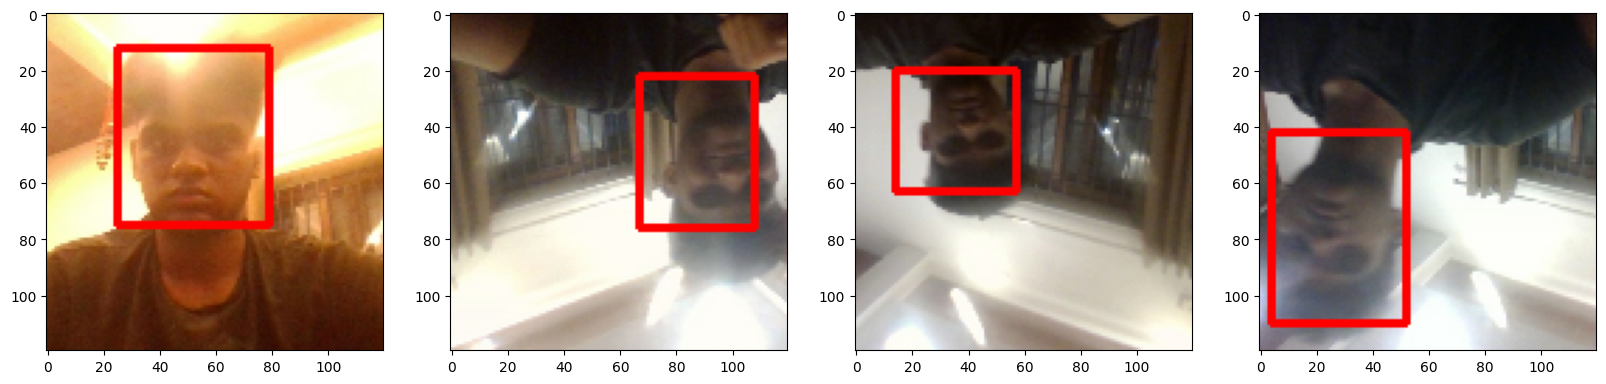

In [118]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        # Convert sample_image to cv::UMat
        sample_image_cv2 = cv2.UMat(sample_image)
        
        cv2.rectangle(sample_image_cv2, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                      (255,0,0), 2)
        
        # Convert sample_image_cv2 back to numpy array for display
        sample_image_with_rect = sample_image_cv2.get()
        
        ax[idx].imshow(sample_image_with_rect)
    else:
        ax[idx].imshow(sample_image)


In [5]:
from tensorflow.keras.models import load_model

In [6]:
facetracker = load_model('facetracker.h5')

In [9]:
import cv2
import numpy as np
import tensorflow as tf  # Import TensorFlow if you're using its functions

# Open the webcam
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Unable to open webcam")
    exit()

while cap.isOpened():
    # Read frame from webcam
    ret, frame = cap.read()

    if not ret:
        print("Error: Unable to read frame from webcam")
        break

    # Process the frame here

    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()

KeyboardInterrupt: 